# Featurization, Model Selection and Tuning

## We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all then features are required to build the model or not.

In [643]:
#importing the required libraries
import pandas as pd
import numpy as np

#compare ensemble to each baseline classifier
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings("ignore")

#For visualization
import seaborn as sns
import matplotlib.pyplot as plt  
sns.set(color_codes=True)        #adds color background (have to kill the kernel to see the changes of color)
%matplotlib inline 

#For scientific computations
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler            #For normalizing values

from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

from sklearn.model_selection  import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression       #For logistic regression model
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.utils import resample

import pickle 

In [644]:
input1 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 5 - FMST\\signal-data.csv')
input1.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [645]:
print('Shape of data file is: {}'.format(input1.shape))

Shape of data file is: (1567, 592)


We can observe that there are multiple missing values in few rows and columns. Hence data cleansing is very much neccessary to get appropriate results.

### Data Cleansing

In [646]:
input1.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object

We can observe that all the columns are float data types except for the target variable which is of integer type.

Count of missing values in only few columns are observed by above code. Let's try to scan if there are more than 50% of the particular column are having missing values.

In [647]:
count = 0
a = input1.isnull().sum()

print('Columns having more than 700 missing values: ')
print('')

j = []
for i in a.keys():
    if(a[i] > 700):
        print(i, a[i])
        count = count + 1
        j.append(i)

print('')
print('There are more than 700 missing values in {} columns.'.format(count))

Columns having more than 700 missing values: 

72 794
73 794
85 1341
109 1018
110 1018
111 1018
112 715
157 1429
158 1429
220 1341
244 1018
245 1018
246 1018
247 715
292 1429
293 1429
345 794
346 794
358 1341
382 1018
383 1018
384 1018
385 715
492 1341
516 1018
517 1018
518 1018
519 715
578 949
579 949
580 949
581 949

There are more than 700 missing values in 32 columns.


We will remove these columns as there are a lot of missing values which might result in incorrect interpretations.

In [648]:
input1.drop(j, axis = 1, inplace = True)

In [649]:
print('Shape of data file after removing columns having high number of missing values: {}'.format(input1.shape))

Shape of data file after removing columns having high number of missing values: (1567, 560)


Since the range of values in most of the columns are highly varied, it is better to replace them with zeros instead of treating with mean, median or repeated values.

In [650]:
input2 = input1.replace(np.NaN, 0)
input2.isnull().sum()

Time         0
0            0
1            0
2            0
3            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 560, dtype: int64

In [651]:
input2.isnull().any().any()

False

Lets drop 'Time' column which might not be useful in our classification.

In [652]:
input2.drop('Time', axis = 1, inplace = True)

### Data Analysis and Visualization

In [653]:
input2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1567.0,3002.910638,200.204648,0.0000,2965.67000,3010.9200,3056.5400,3356.3500
1,1567.0,2484.700932,184.815753,0.0000,2451.51500,2498.9100,2538.7450,2846.4400
2,1567.0,2180.887035,209.206773,0.0000,2180.70000,2200.9556,2218.0555,2315.2667
3,1567.0,1383.901023,458.937272,0.0000,1080.11605,1283.4368,1590.1699,3715.0417
4,1567.0,4.159516,56.104457,0.0000,1.01100,1.3101,1.5188,1114.5366
...,...,...,...,...,...,...,...,...
586,1567.0,0.021445,0.012366,-0.0169,0.01340,0.0205,0.0276,0.1028
587,1567.0,0.016464,0.008815,0.0000,0.01060,0.0148,0.0203,0.0799
588,1567.0,0.005280,0.002869,0.0000,0.00330,0.0046,0.0064,0.0286
589,1567.0,99.606461,93.895701,0.0000,44.36860,71.7780,114.7497,737.3048


- After missing value treatment we can observe that there are still wide range of values in the dataset as it contains useful information, irrelevant information as well as noise. 
- Most of the missing values are replcaed by zeros and hence we can see that most of the features are having minimum value as 0.

In [654]:
target_counts = input2.groupby('Pass/Fail').size()
print(target_counts);

Pass/Fail
-1    1463
 1     104
dtype: int64


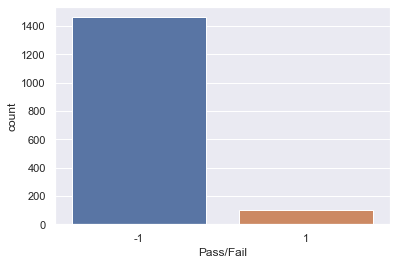

In [655]:
sns.countplot(input2['Pass/Fail']);

- Out of 1567 production entities only 104 have passed and remaining 1463 have failed.
- We can observe that there is target class imbalance. There is a high probability of misclassification of the minority class as compared to the majority class while using standard classifiers.

In [656]:
skew = input2.skew()
print(skew)

0           -12.896537
1           -10.845093
2           -10.135049
3             1.341710
4            19.733978
               ...    
586           1.434324
587           1.940926
588           2.022971
589           2.713682
Pass/Fail     3.487359
Length: 559, dtype: float64


- We can observe that there are few columns which are highly skewed both having positive and negative values. These values will have high impact later on in classification.

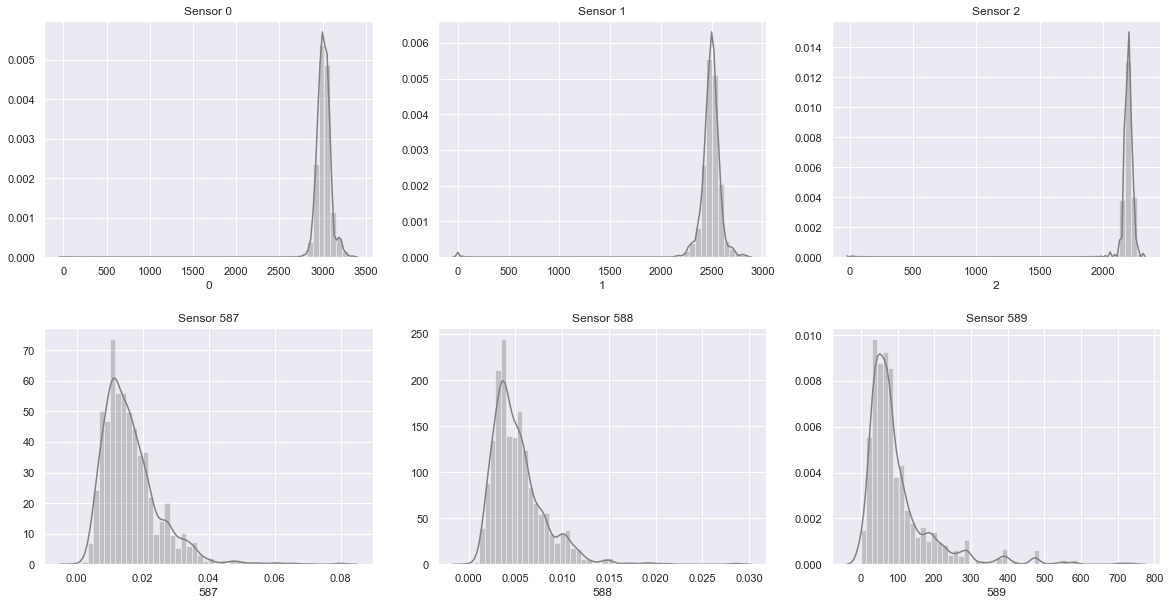

In [657]:
# Univariate Analysis of measurements of first 3 and last 3 sensors.

plt.figure(figsize= (20,10));

plt.subplot(2,3,1);
plt.title('Sensor 0')
sns.distplot(input2['0'],color='grey');

plt.subplot(2,3,2);
plt.title('Sensor 1')
sns.distplot(input2['1'],color='grey');

plt.subplot(2,3,3);
plt.title('Sensor 2')
sns.distplot(input2['2'],color='grey');

plt.subplot(2,3,4);
plt.title('Sensor 587')
sns.distplot(input2['587'],color='grey');

plt.subplot(2,3,5);
plt.title('Sensor 588')
sns.distplot(input2['588'],color='grey');

plt.subplot(2,3,6);
plt.title('Sensor 589')
sns.distplot(input2['589'],color='grey');

plt.subplots_adjust(hspace=0.3)

From the above plots we can observe that:
- First 3 sensors are almost normally distributed and last 3 sensors are slightly right skewed/positively skewed.
- In the first 3 sensors even though most of the values are having values above 2000, there are values which are starting from 0.
- Sensor 589 have values ranging from 0 to 790 where most of the values are around 100.
- Sensor 587 and 588 have values in decimals. Thus as discussed earlier we have large range of values between different sensor readings.

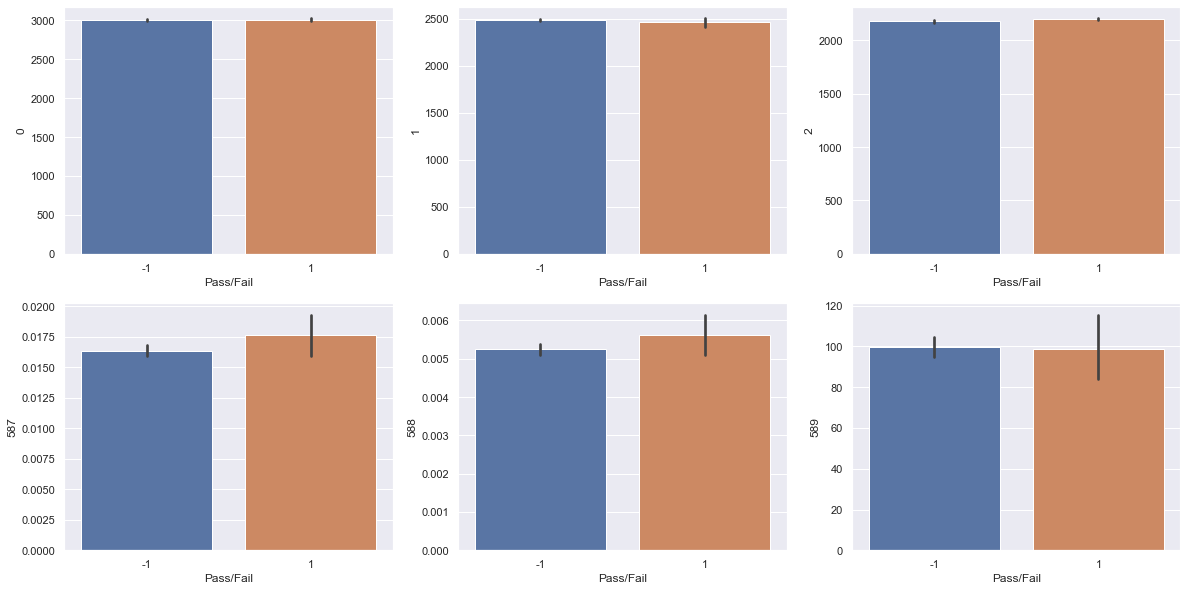

In [658]:
#Bivariate analysis
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
sns.barplot(input2['Pass/Fail'], input2['0']);

plt.subplot(2,3,2)
sns.barplot(input2['Pass/Fail'], input2['1']);

plt.subplot(2,3,3)
sns.barplot(input2['Pass/Fail'], input2['2']);

plt.subplot(2,3,4)
sns.barplot(input2['Pass/Fail'], input2['587']);

plt.subplot(2,3,5)
sns.barplot(input2['Pass/Fail'], input2['588']);

plt.subplot(2,3,6)
sns.barplot(input2['Pass/Fail'], input2['589']);

From the above plots we can observe that:
- Almost all the above sensors given in the graph have almost equal values for both Passed and Failed entities.
- More outliers are found in Passed entities compared to Failed ones in readings of sensors 587, 588 and 589. Thus there is a high variation.
- Sensors 0, 1 and 2 have have similar readings for both passed and failed entities.

Seperating the target column and the predictors from the data

In [659]:
predictors = input2.drop(['Pass/Fail'], axis=1)
target     = input2.loc[:,'Pass/Fail']

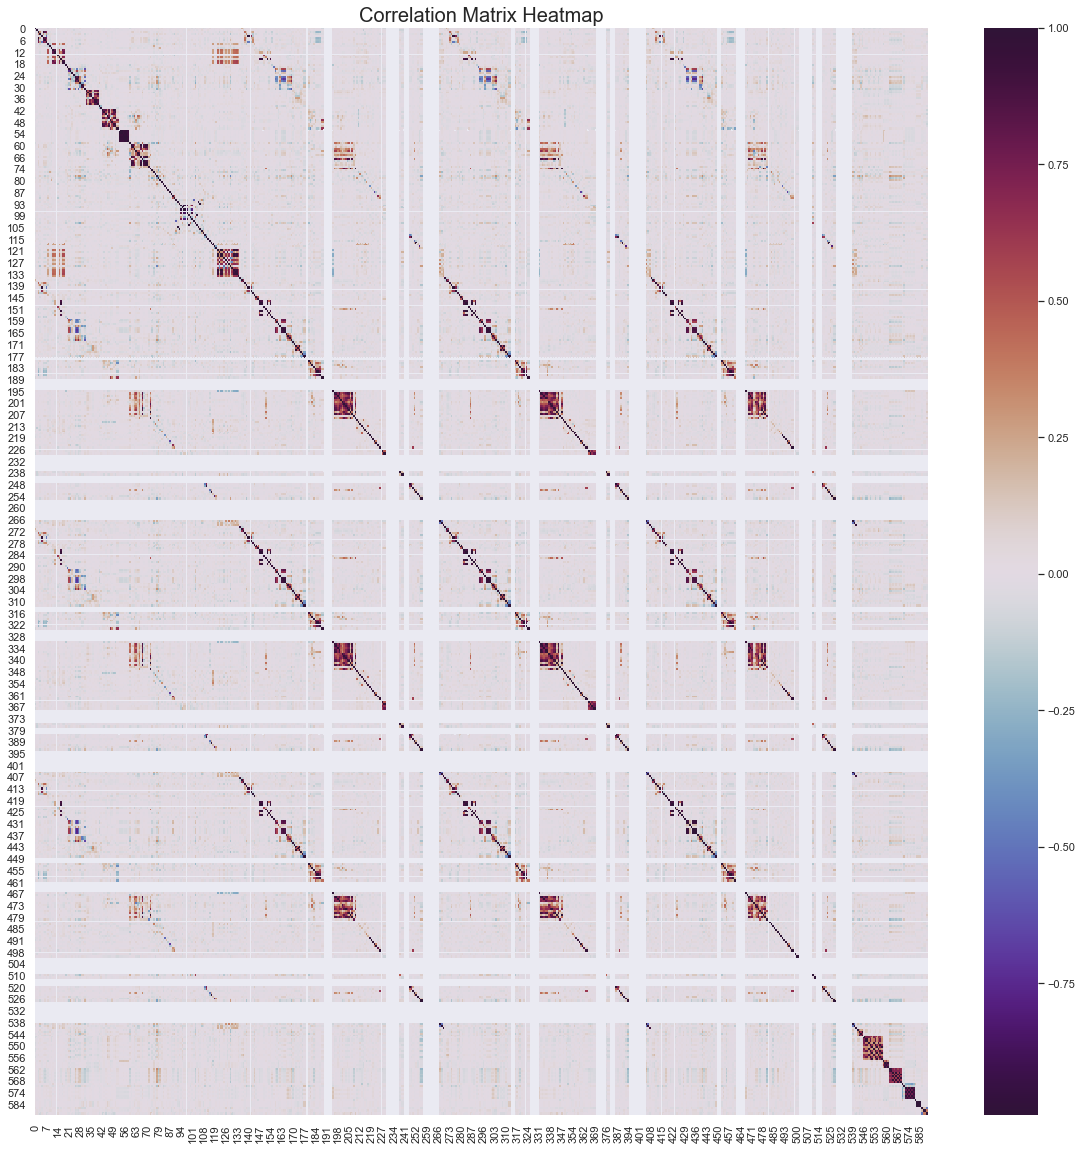

In [660]:
# Correlation matrix heatmap

plt.rcParams['figure.figsize'] = (20, 20)
plt.title('Correlation Matrix Heatmap', fontsize = 20)
sns.heatmap(predictors.corr(), cmap = "twilight_shifted");

As seen from the heatmap above only few sensor readings show correlation out of 559 readings. Thus multicolinearity might not occur using the current dataset. Note: We are using rcParams (Runtime Configuration of python) to adjust the figure size by changing the defaults.

### Data pre-processing

We have already seperated the target column and the predictors from the original dataset in the above steps which are under the names 'target' and 'predictors' respectively.

In [661]:
print('Shape of predictors data : {}'.format(predictors.shape))
print('Shape of target data     : {}'.format(target.shape))

Shape of predictors data : (1567, 558)
Shape of target data     : (1567,)


As we already checked above the target column is imbalanced. We will see that again and fix this target class imbalance using suitable method.

In [662]:
target_counts

Pass/Fail
-1    1463
 1     104
dtype: int64

Next steps include:
- Split the data into train and test data (Ideally train and test dataset should be from the same distribution).
- Standardize the train data and then use the stats of train data on test dataset. Since the values are of wide range in different columns.
- Not all the models are affected by the magnitude of variables. For example Logistic regression and Tree based algorithms might not need standardization as they are not sensitive to magnitude of variables.
- We are splitting the data first to avoid information leakage from train to test.
- We will use the most popularly used SMOTE (Synthetic Minority Oversampling Technique) to rectify target class imbalance.

In [663]:
# Split the data to train and test

X = predictors
Y = target

# taking 70:30 training and test set
test_size = 0.30 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=1)

In [664]:
#For future use
f1 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 5 - FMST\\signal-data.csv')

f1_imputed = f1.fillna(0)

fx = f1_imputed.drop(['Time', 'Pass/Fail'], axis=1)
fy = f1_imputed['Pass/Fail']

# taking 70:30 training and test set
test_size = 0.30 

Xf_train, Xf_test, yf_train, yf_test = train_test_split(fx, fy, test_size=test_size, random_state=1)

In [665]:
# Scaling independent data to acheive better results
sc = StandardScaler()
X_train_sc =  sc.fit_transform(X_train)
X_test_sc  =  sc.fit_transform(X_train)

In [666]:
print("Before UpSampling, counts of label '+1': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '-1': {}".format(sum(y_train==-1)))

#Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)

print('')
print("After UpSampling, counts of label '+1': {}".format(sum(y_train_sm==1)))
print("After UpSampling, counts of label '-1': {}".format(sum(y_train_sm==-1)))

print('')
print('After UpSampling, the shape of train_X: {}'.format(X_train_sm.shape))
print('After UpSampling, the shape of train_y: {}'.format(y_train_sm.shape))

Before UpSampling, counts of label '+1': 72
Before UpSampling, counts of label '-1': 1024

After UpSampling, counts of label '+1': 1024
After UpSampling, counts of label '-1': 1024

After UpSampling, the shape of train_X: (2048, 558)
After UpSampling, the shape of train_y: (2048,)


As we can see above after using SMOTE upsampling the samples of minority class has increased and now equal to that of majority class. Also, there is no information loss. 

### Model training, testing and tuning

In [667]:
# Let us use simple KNN model on our data set

knn_model1 = KNeighborsClassifier()
knn_model1.fit(X_train_sm,y_train_sm)
knn_predict1 = knn_model1.predict(X_test)
knn_score1   = accuracy_score(y_test,knn_predict1)

print("KNN Model Score:")
print(knn_score1*100)

KNN Model Score:
92.1443736730361


The accuracy score of KNN model seems to be 92.14% which is pretty good. Lets try to cross validate using popular CV techniques.

In [668]:
# Cross Validation techniques

# K-fold cross validation
num_folds = 10
kfold = KFold(n_splits=num_folds)

result1 = cross_val_score(knn_model, X, Y, cv=kfold)
# print(result1)
print("Accuracy: %.2f%% (%.2f%%)" % (result1.mean()*100.0, result1.std()*100.0))

# print('')
# # use cross_val_predict to generate K-Fold predictions
# k_predictions = cross_val_predict(lr_model, X, Y, cv=kfold)
# print(k_predictions)

Accuracy: 92.92% (4.49%)


Using K-fold CV with number of folds as 10, we can observe that the mean accuracy is 93.30% with standard deviation of 4.43%. Thus, this model can achieve accuracy of 97% on the higher side and 89% on the lower side. At 95% confidence interval (at 1.96 * std) this model can achieve highest accuracy of nearing 100% and minimum of 85% which is pretty good.

In [669]:
# Leave One Out Cross Validation
loocv = LeaveOneOut()

result2 = cross_val_score(knn_model, X, Y, cv=loocv)
print("Accuracy: %.2f%% (%.2f%%)" % (result2.mean()*100.0, result2.std()*100.0))

Accuracy: 92.98% (25.55%)


Using Leave One Out CV mean accuracy is almost same to the accuracy given by K-fold cross validation. But the standard deviation of the accuracy is around 25% which is quite large. Ideally LOOCV is not recommended on large datasets as it takes higher computation time.

In [670]:
# Stratified K-fold
skf = StratifiedKFold(n_splits=5, random_state=None)

result3 = cross_val_score(knn_model, X, Y, cv=skf)
print("Accuracy: %.2f%% (%.2f%%)" % (result3.mean()*100.0, result3.std()*100.0))

Accuracy: 92.98% (0.49%)


Using stratified K-fold the mean accuracy (93.17%) is almost same compared to other CV techniques used. It is generally a better approach when dealing with both bias and variance. A randomly selected fold might not adequately represent the minor class, particularly in cases where there is a huge class imbalance.

In [671]:
# Let's check hyperparameters for few classification models

lrcl =  LogisticRegression()
nbcl =  GaussianNB()
dtcl = DecisionTreeClassifier()
knncl =  KNeighborsClassifier()
svcl = SVC()
rfcl =  RandomForestClassifier()
bgcl =  BaggingClassifier()

In [672]:
for clf, label in zip([lrcl, nbcl, dtcl, knncl, svcl, rfcl, bgcl], 
    ['Logistic Regression', 'Naive Bayes Classifier', 'Decision Tree Classifier', 'K-Nearest Neighbor Classifier', 'SVM Classifer', 'Random Forest Classifier', 'Bagging Classfier']):
    print("Model name: ", label)
    print("Hyperparameters:", clf.get_params() )
    print('')

Model name:  Logistic Regression
Hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Model name:  Naive Bayes Classifier
Hyperparameters: {'priors': None, 'var_smoothing': 1e-09}

Model name:  Decision Tree Classifier
Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Model name:  K-Nearest Neighbor Classifier
Hyperparameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Mode

In [673]:
# For future use
rfcl.fit(Xf_train, yf_train)

RandomForestClassifier()

As we all know not all the hyperparameters are important. So we will use Grid search CV and Random search CV to find the best hyperparameters for the model used.

In [674]:
# Gridsearch
knncl.fit(X_train_sm, y_train_sm)

param_grid = {'n_neighbors': list(range(1,9)),
             'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }

gs = GridSearchCV(knncl,param_grid,cv=10)
gs.fit(X_train_sm, y_train_sm)
print('The best hyperparameter combination with their values for this dataset is: {}'.format(gs.best_params_))

The best hyperparameter combination with their values for this dataset is: {'algorithm': 'auto', 'n_neighbors': 2}


In [675]:
# Let us use simple KNN model on our data set

knn_model2 = KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto')
knn_model2.fit(X_train_sm,y_train_sm)

knn_predict2 = knn_model2.predict(X_test)
knn_score2   = accuracy_score(y_test,knn_predict2)

print("KNN Model Score:")
print(knn_score2*100)

KNN Model Score:
93.20594479830149


In [676]:
# Random search

param_dist = {'n_neighbors': list(range(1,9)),
             'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }

rs = RandomizedSearchCV(knncl, param_distributions=param_dist, n_iter=10)
rs.fit(X_train_sm, y_train_sm)
print('The best hyperparameter combination with their values for this dataset is: {}'.format(gs.best_params_))

The best hyperparameter combination with their values for this dataset is: {'algorithm': 'auto', 'n_neighbors': 2}


We got the same combination of hyperparameters by both of the search methods that is Grid search and Randomized search.

In [677]:
print('The accuracy score with default values of KNN model is          : {}'.format(knn_score1*100))
print('The accuracy score after hyperparameter tuning on KNN model is  : {}'.format(knn_score2*100))

The accuracy score with default values of KNN model is          : 92.1443736730361
The accuracy score after hyperparameter tuning on KNN model is  : 93.20594479830149


We can observe that there is a slight improvement in the accuracy after using hyperparameter tuning. This will prove to be very helpful when handling larger datasets with complex algorithms.

Lets try to implement same model on dataset having only important features. We will use Forward Feature Construction method. This method is computationally expensive and is not recommended for huge datasets.

In [678]:
# Forward Feature Construction for selecting most important features

ffc = f_regression(X,Y)

variable = [ ]
for i in range(0,len(X.columns)-1):
    if ffc[0][i] >=0.5:       
        variable.append(X.columns[i])

In [679]:
variable

['1',
 '2',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '14',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '40',
 '47',
 '53',
 '54',
 '55',
 '56',
 '57',
 '59',
 '61',
 '63',
 '64',
 '65',
 '67',
 '75',
 '76',
 '78',
 '79',
 '80',
 '81',
 '83',
 '84',
 '86',
 '87',
 '88',
 '89',
 '90',
 '93',
 '95',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '106',
 '114',
 '115',
 '118',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '135',
 '137',
 '138',
 '143',
 '144',
 '145',
 '146',
 '151',
 '153',
 '155',
 '159',
 '160',
 '161',
 '163',
 '164',
 '165',
 '166',
 '167',
 '170',
 '172',
 '174',
 '175',
 '180',
 '181',
 '182',
 '183',
 '188',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '203',
 '204',
 '205',
 '207',
 '208',
 '210',
 '211',
 '213',
 '214',
 '216',
 '221',
 '222',
 '224',
 '225',
 '227',
 '238',
 '239',
 '249',
 '254',
 '269',
 '270',
 '271',
 '272',
 '2

In [680]:
print('Number of top features chosen using Forward Feature Construction technique: {}'.format(len(variable)))

Number of top features chosen using Forward Feature Construction technique: 263


In [681]:
var_l = list(variable)
df_new = input2[var_l].copy()

In [682]:
df_new.head()

,1,2,5,6,7,8,9,10,14,20,...,571,572,573,574,575,576,577,582,587,588
0,2564.00,2187.7333,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,7.9558,1.4026,...,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0.5005,0.0000,0.0000
1,2465.14,2230.4222,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,10.1548,1.3825,...,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.5019,0.0201,0.0060
2,2559.94,2186.4111,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,9.5157,1.4123,...,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.4958,0.0484,0.0148
3,2479.90,2199.0333,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,9.6052,1.4011,...,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.4990,0.0149,0.0044
4,2502.87,2233.3667,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,10.5661,1.3888,...,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0.4800,0.0149,0.0044


In [683]:
print('Shape of the new data file after Forward Feature Selection method is: {}'.format(df_new.shape))

Shape of the new data file after Forward Feature Selection method is: (1567, 263)


In [684]:
# taking 70:30 training and test set
test_size = 0.30 

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(df_new, Y, test_size=test_size, random_state=1)

In [685]:
print("Before UpSampling, counts of label '+1': {}".format(sum(y_train_e==1)))
print("Before UpSampling, counts of label '-1': {}".format(sum(y_train_e==-1)))

#Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_train_sm1, y_train_sm1 = sm.fit_resample(X_train_e, y_train_e)

print('')
print("After UpSampling, counts of label '+1': {}".format(sum(y_train_sm1==1)))
print("After UpSampling, counts of label '-1': {}".format(sum(y_train_sm1==-1)))

print('')
print('After UpSampling, the shape of train_X: {}'.format(X_train_sm1.shape))
print('After UpSampling, the shape of train_y: {}'.format(y_train_sm1.shape))

Before UpSampling, counts of label '+1': 72
Before UpSampling, counts of label '-1': 1024

After UpSampling, counts of label '+1': 1024
After UpSampling, counts of label '-1': 1024

After UpSampling, the shape of train_X: (2048, 263)
After UpSampling, the shape of train_y: (2048,)


In [686]:
knn_model3 = KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto')
knn_model3.fit(X_train_sm1,y_train_sm1)

knn_predict3 = knn_model3.predict(X_test_e)
knn_score3   = accuracy_score(y_test_e,knn_predict3)

print("KNN Model Score:")
print(knn_score3*100)

KNN Model Score:
78.343949044586


Though the accuracy has reduced after using only important features computational speed has increased and thus, we can use these methods for larger datasets.

In [687]:
y_predict_e = knn_model3.predict(X_test_e)

In [688]:
print("KNN model score on reduced dataset (train data):",knn_model3.score(X_train_e, y_train_e))
print("KNN model score on reduced dataset (test data) :",knn_model3.score(X_test_e, y_test_e))
print('')
print("Confusion Matrix when KNN is applied on reduced dataset:\n",metrics.confusion_matrix(y_predict_e,y_test_e))
print('')
print("Classification Report when KNN applied on reduced dataset:\n",metrics.classification_report(y_predict_e,y_test_e))

KNN model score on reduced dataset (train data): 1.0
KNN model score on reduced dataset (test data) : 0.7834394904458599

Confusion Matrix when KNN is applied on reduced dataset:
 [[363  26]
 [ 76   6]]

Classification Report when KNN applied on reduced dataset:
               precision    recall  f1-score   support

          -1       0.83      0.93      0.88       389
           1       0.19      0.07      0.11        82

    accuracy                           0.78       471
   macro avg       0.51      0.50      0.49       471
weighted avg       0.72      0.78      0.74       471



Observations from model score, confusion matrix and Classification report when KNN is fit on dimensionally reduced dataset:
- Model score is above 100% for train and 78% for test data which means model is overfitted. We will try other models which are not influenced by overfitting.
- Precision is 83% and 19% meaning the given percentage from total predicted values actually belong to the respective classes.
- Recall is 93% and 7% when classifying, meaning out of all the values that actually belong to a particular class, how much is predicted as that class.
- F1-score is 88% and 11%. The F1 score is the harmonic mean of precision and recall.
- Overall we can observe that minority class is not predicted correctly in most of the instances.

Before trying out different models let us try to check if the achieved train and test accuracies might change if a different sample population can lead to 
new train and test accuracies.

In [689]:
# Number of iterations for bootstrapping
bootstrap_iteration = 10
accuracy = []

In [690]:
knn_model4 = KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto')
    
for i in range(bootstrap_iteration):
    X_, y_ = resample(X_train_e, y_train_e)
    knn_model4.fit(X_, y_)
    y_pred = knn_model4.predict(X_test_e)
    
    acc = accuracy_score(y_pred, y_test_e)
    accuracy.append(acc)

In [691]:
accuracy = np.array(accuracy)
print('Accuracy Score')
print('Average: ', accuracy.mean())
print('Standard deviation: ', accuracy.std())

Accuracy Score
Average:  0.9095541401273884
Standard deviation:  0.004473738323928975


In [692]:
print("KNN model score on original dataset samples              :",accuracy_score(y_predict_e, y_test_e).mean())
print("KNN model score after using samples from bootstrap method:",accuracy.mean())

KNN model score on original dataset samples              : 0.7834394904458599
KNN model score after using samples from bootstrap method: 0.9095541401273884


We can observe that accuracy is changed when different sample population is used.

In [693]:
# Pipeline all the models

pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(random_state=1))])
pipe_nb = Pipeline([('scl', StandardScaler()), ('clf', GaussianNB())])
pipe_dt = Pipeline([('scl', StandardScaler()), ('clf', DecisionTreeClassifier())])
pipe_knn = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto'))])
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC())])
pipe_rf = Pipeline([('scl', StandardScaler()), ('clf', RandomForestClassifier())])
pipe_bc = Pipeline([('scl', StandardScaler()), ('clf', BaggingClassifier())])

pipe_lr.fit(X_train_e, y_train_e) 
pipe_nb.fit(X_train_e, y_train_e) 
pipe_dt.fit(X_train_e, y_train_e) 
pipe_knn.fit(X_train_e, y_train_e) 
pipe_svc.fit(X_train_e, y_train_e) 
pipe_rf.fit(X_train_e, y_train_e) 
pipe_bc.fit(X_train_e, y_train_e) 

# Training dataset Scores 
lr_train = pipe_lr.score(X_train_e, y_train_e)
nb_train = pipe_nb.score(X_train_e, y_train_e)
dt_train = pipe_dt.score(X_train_e, y_train_e)
knn_train = pipe_knn.score(X_train_e, y_train_e)
svc_train = pipe_svc.score(X_train_e, y_train_e)
rf_train = pipe_rf.score(X_train_e, y_train_e)
bc_train = pipe_bc.score(X_train_e, y_train_e)

# Testing dataset Scores
lr_test = pipe_lr.score(X_test_e, y_test_e)
nb_test = pipe_nb.score(X_test_e, y_test_e)
dt_test = pipe_dt.score(X_test_e, y_test_e)
knn_test = pipe_knn.score(X_test_e, y_test_e)
svc_test = pipe_svc.score(X_test_e, y_test_e)
rf_test = pipe_rf.score(X_test_e, y_test_e)
bc_test = pipe_bc.score(X_test_e, y_test_e)

In [694]:
data = {'Train dataset Accuracy': [lr_train, nb_train, dt_train, knn_train, svc_train, rf_train, bc_train],
        'Test dataset Accuracy': [lr_test, nb_test, dt_test, knn_test, svc_test, rf_test, bc_test]} 

pd.DataFrame(data,
             index = ['Logistic Regression', 'Naive Bayes', 'Decision Tree','KNN',
                      'SVM', 'Random Forest', 'Bagging Classifier' ])

,Train dataset Accuracy,Test dataset Accuracy
Logistic Regression,0.968066,0.910828
Naive Bayes,0.284672,0.259023
Decision Tree,1.000000,0.898089
KNN,0.945255,0.927813
SVM,0.945255,0.932059
Random Forest,1.000000,0.932059
Bagging Classifier,0.983577,0.929936


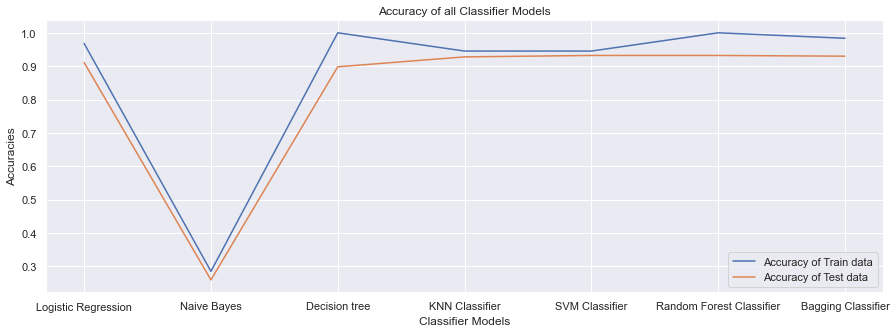

In [695]:
plt.figure(figsize=(15,5))

# line 1 points
x1 = ['Logistic Regression', 'Naive Bayes', 'Decision tree', 'KNN Classifier', 'SVM Classifier', 'Random Forest Classifier', 
       'Bagging Classifier']
y1 = [lr_train, nb_train, dt_train, knn_train, svc_train, rf_train, bc_train]

# plotting the line 1 points 
plt.plot(x1, y1, label = "Accuracy of Train data")

# line 2 points
x2 = ['Logistic Regression', 'Naive Bayes', 'Decision tree', 'KNN Classifier', 'SVM Classifier', 'Random Forest Classifier', 
       'Bagging Classifier']
y2 = [lr_test, nb_test, dt_test, knn_test, svc_test, rf_test, bc_test]

# plotting the line 2 points 
plt.plot(x2, y2, label = "Accuracy of Test data")

plt.xlabel('Classifier Models')
plt.ylabel('Accuracies')

# Set a title of the current axes.
plt.title('Accuracy of all Classifier Models')
plt.legend()
plt.show();

Conclusion: 
- We can observe that Random Forest Classifier has best accuracies both for train and test datasets compared to all other models. 
- It is known for its efficiency on large databases. Also it can handle thousands of input variables without variable deletion.
- It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.

### Pickle the model for future use

In [696]:
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(rfcl) 

In [697]:
# Load future data
future_pred = pd.read_excel('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 5 - FMST\\Future_predictions.xlsx')
future_pred.head()

,Time,0,1,2,3,4,5,6,7,8,...,580,581,582,583,584,585,586,587,588,589
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [698]:
print('Shape of data file is: {}'.format(future_pred.shape))

Shape of data file is: (18, 591)


In [699]:
Xf = future_pred.drop(['Time'], axis=1)
Xf_time = future_pred.loc[:,'Time']
Xf_imputed = Xf.fillna(0)

In [700]:
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
result = rf_from_pickle.predict(Xf_imputed) 

In [701]:
result_df = pd.DataFrame(result, columns = ['Pass/Fail'])
result_df

,Pass/Fail
0,-1
1,-1
2,1
3,-1
4,-1
5,-1
6,-1
7,-1
8,-1
9,-1


In [702]:
Xf_imputed['Time'] = Xf_time
Xf_imputed['Pass_Fail'] = result_df

In [703]:
Xf_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,582,583,584,585,586,587,588,589,Time,Pass_Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000,2008-07-19 11:55:00,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,2008-07-19 12:32:00,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,2008-07-19 13:17:00,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,2008-07-19 14:43:00,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,2008-07-19 15:22:00,-1


In [704]:
print('Shape of final data file is: {}'.format(Xf_imputed.shape))

Shape of final data file is: (18, 592)


Conclusion:
- Overall the dataset had multiple columns with missing values. As a result EDA proved to be one of the very important step for this case.
- Since we had multiple features, analysis using visualization of all features was not possible.
- Standardization, Cross Validation techniques, Dimensionality reduction, Hyperparameter tuning helped a lot in improving the overall performance since we had more than 500 features.
- Comparing multiple models, Tree based models gave more accurate results.
- Finally pickle method can be used to save the final model and use it on future dataset to make predications.